# Reranking for Retrieval-Augmented Generation (RAG) with Chroma and LiteLLM

This notebook demonstrates how to implement a **Retrieval-Augmented Generation (RAG)** pipeline with **reranking** using **Chroma Vector Database**, **Cross-Encoder models**, and **LiteLLM** with the **Gemini model**. The system processes a folder of PDF documents, builds a knowledge base, retrieves relevant information, and reranks the results to improve the quality of responses. Below is an overview of the tools and methods used.

---

## Tools Used

### Chroma Vector Database
- A vector database designed for storing and querying embeddings.
- Enables efficient similarity search for retrieving semantically relevant documents.

### Sentence Transformers
- A library for generating high-quality embeddings (vector representations) of text.
- Uses pre-trained models like `all-MiniLM-L6-v2` to convert text into embeddings.

### LangChain
- A framework for working with text data, including text splitting and chunking.
- The `RecursiveCharacterTextSplitter` is used to split text into semantically meaningful chunks.

### LiteLLM
- A lightweight library for interacting with large language models (LLMs).
- Used here to call the **Gemini model** for generating responses and reranking based on retrieved context.

### Cross-Encoder Models
- Specialized models for reranking retrieved documents by jointly encoding query-document pairs.
- Provides more accurate relevance scores compared to bi-encoders.

### PyPDF2
- A library for extracting text from PDF files.
- Used to process all PDFs in a specified folder.

---

## Methods and Steps

### Step 1: Extract Text from PDFs
- All PDF files in a specified folder are processed using **PyPDF2**.
- The text from each PDF is extracted and combined into a single string.

### Step 2: Split Text into Chunks
- The combined text is split into smaller chunks using **LangChain's `RecursiveCharacterTextSplitter`**.
- This ensures that the chunks are semantically meaningful and retain context.

### Step 3: Generate Embeddings
- Each text chunk is converted into an embedding (vector representation) using **Sentence Transformers**.
- The embeddings capture the semantic meaning of the text.

### Step 4: Build the Knowledge Base
- The embeddings and corresponding text chunks are stored in the **Chroma Vector Database**.
- This allows for efficient similarity searches based on semantic meaning.

### Step 5: Perform Semantic Search
- A user query is converted into an embedding.
- The most semantically similar chunks are retrieved from the Chroma database.

### Step 6: Rerank Retrieved Documents
- **LLM-based Reranking**: The retrieved documents are reranked using the **Gemini model** to score their relevance to the query.
- **Cross-Encoder Reranking**: The documents are further reranked using a **Cross-Encoder model** for higher accuracy.

### Step 7: Generate Responses
- The top reranked documents are passed as context to the **Gemini model** via **LiteLLM**.
- The model generates a response based on the query and the provided context.

---

## Workflow Overview

### Input
- A folder containing PDF documents.

### Processing
1. Extract text from PDFs.
2. Split text into chunks.
3. Generate embeddings and store them in Chroma.

### Query Handling
1. Convert the query into an embedding.
2. Retrieve the most relevant chunks from Chroma.
3. Rerank the retrieved chunks using LLM and Cross-Encoder models.
4. Generate a response using the Gemini model.

### Output
- A contextually accurate answer to the user's query.

---

## Why This Approach?

- **Contextual Semantic Search**: Goes beyond keyword matching to understand the meaning and context of the query.
- **Efficient Retrieval**: Chroma enables fast and scalable similarity searches.
- **High-Quality Reranking**: Combines LLM and Cross-Encoder models to prioritize the most relevant documents.
- **Accurate Responses**: The Gemini model generates precise and contextually relevant answers.

---

Let’s get started! Below is the full workflow implemented in this notebook.

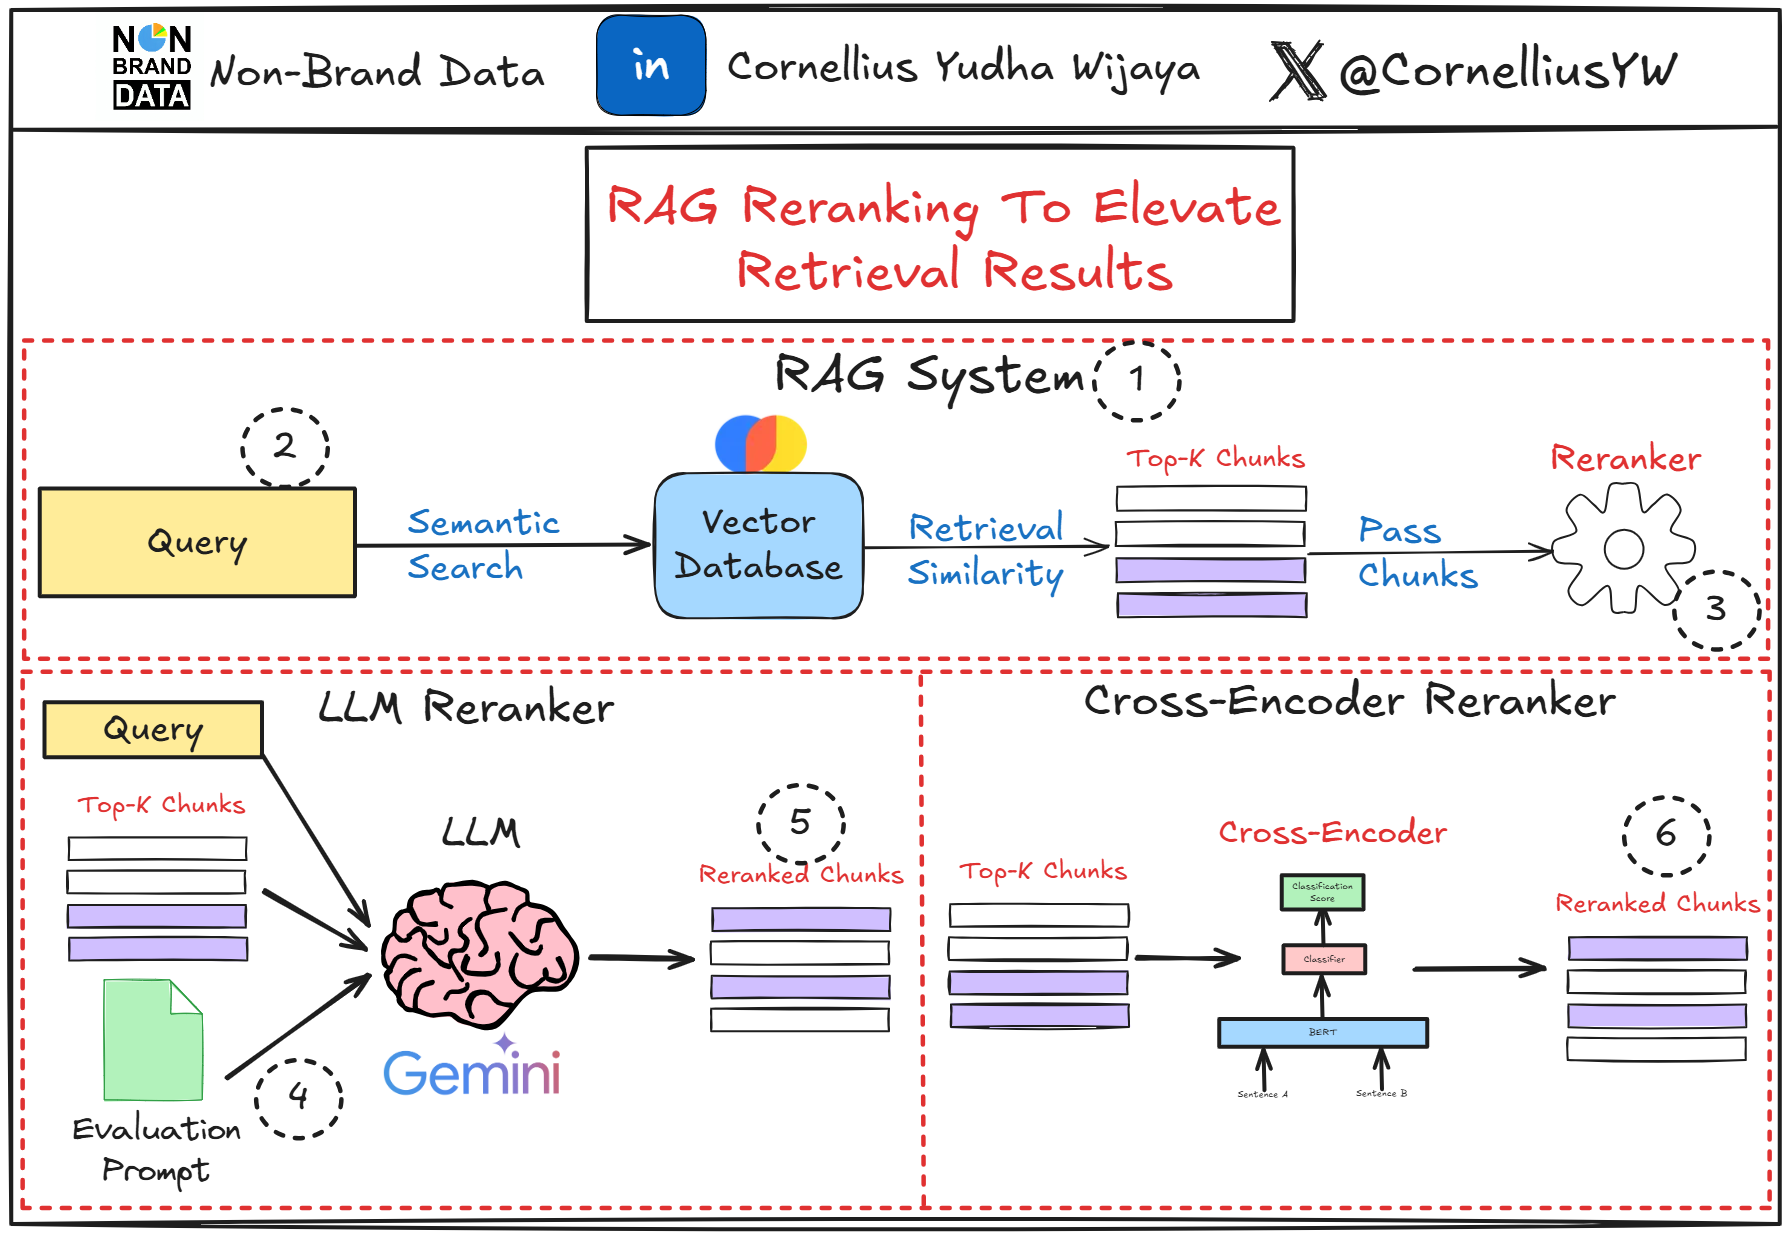

## Install Important Library

In [ ]:
!pip install -q chromadb pypdf2 sentence-transformers litellm langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 95.0 MB/s eta 0:00:

## Import all the libraries and environment variable

In [ ]:
import os
import PyPDF2
from sentence_transformers import SentenceTransformer, CrossEncoder
import chromadb
import litellm
from litellm import completion
from langchain.text_splitter import RecursiveCharacterTextSplitter
from tqdm import tqdm
import time
import json
import pandas as pd
# Enable debugging for LiteLLM
os.environ['LITELLM_LOG'] = 'DEBUG'

# Set your Gemini API key
GEMINI_API_KEY = "YOUR-API-KEY"  # Replace with your actual API key

## Data Extraction and Chunks splitting

In [ ]:
def extract_text_from_pdfs(folder_path):
    all_text = ""
    for filename in os.listdir(folder_path):
        if filename.endswith(".pdf"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'rb') as file:
                reader = PyPDF2.PdfReader(file)
                for page in reader.pages:
                    all_text += page.extract_text()
    return all_text

# Path to the folder containing PDFs
pdf_folder = "dataset"
all_text = extract_text_from_pdfs(pdf_folder)

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,  # Size of each chunk
    chunk_overlap=50,  # Overlap between chunks to maintain context
    separators=["\n\n", "\n", " ", ""]  # Splitting hierarchy
)

chunks = text_splitter.split_text(all_text)
print(f"Total chunks: {len(chunks)}")

Total chunks: 1237


## Setting up the Vector Database and Store the Embedding

In [ ]:
# Initialize a persistent ChromaDB client
client = chromadb.PersistentClient(path="chroma_db")

# Load the SentenceTransformer model for text embeddings
text_embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Delete existing collection (if needed)
try:
    client.delete_collection(name="knowledge_base")
    print("Deleted existing collection: knowledge_base")
except Exception as e:
    print(f"Collection does not exist or could not be deleted: {e}")

# Create a new collection for text embeddings
collection = client.create_collection(name="knowledge_base")

# Add text chunks to the collection
for i, chunk in enumerate(chunks):
    # Generate embeddings for the chunk
    embedding = text_embedding_model.encode(chunk)

    # Add to the collection with metadata
    collection.add(
        ids=[f"chunk_{i}"],  # Unique ID for each chunk
        embeddings=[embedding.tolist()],  # Embedding vector
        metadatas=[{"source": "pdf", "chunk_id": i}],  # Metadata
        documents=[chunk]  # Original text
    )

print("Text chunks and embeddings stored in ChromaDB.")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Collection does not exist or could not be deleted: Collection knowledge_base does not exist.
Text chunks and embeddings stored in ChromaDB.


## Semantic Search with Embedding

In [ ]:
def semantic_search(query, top_k=5):
    """
    Perform semantic search on the ChromaDB collection.

    Args:
        query (str): The query string.
        top_k (int): Number of top results to retrieve.

    Returns:
        dict: Query results containing documents, embeddings, and metadata.
    """
    # Generate embedding for the query
    query_embedding = text_embedding_model.encode(query)

    # Query the collection
    results = collection.query(
        query_embeddings=[query_embedding.tolist()],  # Convert numpy array to list
        n_results=top_k  # Number of results to retrieve
    )
    return results

## Trying out the retrieval with top 20 chunks

In [ ]:
# Example query
query = "What is the insurance for car?"
results = semantic_search(query, top_k = 20)

# Display results
print(f"Top {len(results['documents'][0])} results for query: '{query}'\n")
for i, (doc, metadata) in enumerate(zip(results['documents'][0], results['metadatas'][0])):
    print(f"Result {i+1}:")
    print(f"Document: {doc}")
    print(f"Metadata: {metadata}\n")

Top 20 results for query: 'What is the insurance for car?'

Result 1:
Document: insurance) 
FINANCIAL RESPONSIBILITY LAW
A state law requiring that all automobile 
drivers show proof that they can pay dam-
ages up to a minimum amount if involved 
in an auto accident. Varies from state to 
state but can be met by carrying a mini-
mum amount of auto liability insurance. 
(See Compulsory auto insurance)
FINITE RISK REINSURANCE
Contract under which the ultimate li-
ability of the reinsurer is capped and on 
which anticipated investment income is
Metadata: {'chunk_id': 678, 'source': 'pdf'}

Result 2:
Document: policyholder’s car from a collision. 
5. Comprehensive, for damage to the poli-
cyholder’s car not involving a collision 
with another car (including damage 
from fire, explosions, earthquakes, floods, and riots), and theft. 6. Uninsured motorists coverage, for costs 
resulting from an accident involving a hit-and-run driver or a driver who does not have insurance. 
AUTO INSURANCE PR

## Setting up LLM Reranker with Evaluation Prompt

In [ ]:
# Define evaluation criteria
chunk_validation_prompt_template = """
{task}
{evaluation_criteria}

Follow these steps to generate your evaluation:
{evaluation_steps}

Please respond using the following JSON schema:

Answer = {json_format}

You MUST provide values for 'Evaluation:' and 'Score' in your answer.

{question}
{context}

Answer: """

rating_json_format = """
{
    "Evaluation": "your rationale for the rating, as a text",
    "Score": "your rating, as a number between 1 and 5"
}
"""

question_template = """Now here are the question (delimited by triple backticks)
Question: ```{question}```
"""

context_template = """here are the context (delimited by triple quotes).
Context: \"\"\"{context}\"\"\"\n
"""

# Tasks, evaluation criteria, and steps
context_task = """You will be given a context and a question.
Your task is to evaluate the question based on the given context and provide a score between 1 and 5 according to the following criteria:"""

context_eval = """- Score 1: The context does not provide sufficient information to answer the question in any way.
- Score 2 or 3: The context provides some relevant information, but the question remains partially answerable, or is unclear/ambiguous.
- Score 4: The context offers sufficient information to answer the question, but some minor details are missing or unclear.
- Score 5: The context provides all necessary information to answer the question clearly and without ambiguity."""

context_steps = """- Read the context and question carefully.
- Analyse and evaluate the question based on the provided evaluation criteria.
- Provide a scaled score between 1 and 5 that reflect your evaluation."""

# Define the request and token limits
REQUEST_LIMIT = 15  # Maximum requests per minute
TOKEN_LIMIT = 1_000_000  # Maximum tokens per minute

# Initialize counters for rate limiting
start_time = time.time()
requests_made = 0
tokens_used = 0

# Define the function to enforce rate limits
def enforce_rate_limit(start_time, requests_made, tokens_used):
    elapsed_time = time.time() - start_time
    if requests_made >= REQUEST_LIMIT or tokens_used >= TOKEN_LIMIT:
        sleep_time = max(0, 60 - elapsed_time)  # Wait until 1 minute has passed
        time.sleep(sleep_time)
        return time.time(), 0, 0  # Reset counters
    return start_time, requests_made, tokens_used

# Function to generate response using LiteLLM with Gemini
def generate_response(query, context):
    """
    Generate a response using the Gemini model via LiteLLM.

    Args:
        query (str): The query string.
        context (str): The context string.

    Returns:
        str: The generated response from the Gemini model.
    """
    # Combine the query and context for the prompt
    prompt = f"Query: {query}\nContext: {context}\nAnswer:"

    # Call the Gemini model via LiteLLM
    response = completion(
        model="gemini/gemini-1.5-flash",  # Use the Gemini model
        messages=[{"content": prompt, "role": "user"}],
        api_key=GEMINI_API_KEY
    )

    # Extract and return the generated text
    return response['choices'][0]['message']['content']

# Define the function to evaluate relevance
def evaluate_context(question, context):
    global start_time, requests_made, tokens_used

    # Enforce rate limits
    start_time, requests_made, tokens_used = enforce_rate_limit(start_time, requests_made, tokens_used)

    # Prepare the prompt for relevance evaluation
    prompt = chunk_validation_prompt_template.format(
        task=context_task,
        evaluation_criteria=context_eval,
        evaluation_steps=context_steps,
        json_format=rating_json_format,
        question=question_template.format(question=question),
        context=context_template.format(context=context)
    )

    # Generate the response using Gemini
    response = generate_response(prompt, "")

    # Update the counters
    requests_made += 1
    tokens_used += len(prompt.split())  # Approximate token count

    # Parse the response
    try:
        # Extract JSON part from the response (if any)
        json_start = response.find("{")
        json_end = response.rfind("}") + 1
        json_response = response[json_start:json_end]
        evaluation = json.loads(json_response)
        return evaluation
    except json.JSONDecodeError:
        return {"Evaluation": "Invalid JSON response", "Score": 0}

# Function to rerank documents using LLM
def rerank_with_llm(query, documents):
    scores = []
    evaluations = []

    # Evaluate each document with a progress bar
    for doc in tqdm(documents, desc="Reranking documents with LLM"):
        evaluation = evaluate_context(query, doc)
        scores.append(evaluation["Score"])
        evaluations.append(evaluation["Evaluation"])

    # Sort documents based on scores
    reranked_docs = [doc for _, doc in sorted(zip(scores, documents), reverse=True)]
    return reranked_docs, scores, evaluations

# Perform LLM reranking
llm_reranked_docs, llm_scores, llm_evaluations = rerank_with_llm(query, results['documents'][0])

# Display LLM reranked documents
print("\nLLM Reranked Documents:")
for i, (doc, score, evaluation) in enumerate(zip(llm_reranked_docs, llm_scores, llm_evaluations)):
    print(f"{i+1}. Score: {score}")
    print(f"Evaluation: {evaluation}")
    print(f"Document: {doc[:100]}...\n")

Reranking documents with LLM: 100%|██████████| 20/20 [01:09<00:00,  3.46s/it]


LLM Reranked Documents:
1. Score: 3
Evaluation: The provided text mentions auto liability insurance as a way to meet state financial responsibility laws regarding car accidents.  However, it doesn't define car insurance broadly or explain different types of coverage.  The context only offers a very narrow, specific piece of information about one aspect of car insurance.
Document: policyholder’s car from a collision. 
5. Comprehensive, for damage to the poli-
cyholder’s car not i...

2. Score: 3
Evaluation: The context describes several types of car insurance coverage (collision, comprehensive, uninsured motorists), but doesn't provide specifics on the details of each (premiums, coverage limits etc.).  The question is too broad. To answer it fully would require defining which type of car insurance is being asked about. Therefore, the context gives some information but is insufficient for a complete answer.
Document: insurance) 
FINANCIAL RESPONSIBILITY LAW
A state law requiring that al

## Cross-Encoder Reranking

In [ ]:
# Function to evaluate relevance using Cross-Encoder
def evaluate_context_cross_encoder(query, context):
    cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
    score = cross_encoder.predict([(query, context)])[0]
    return score

# Function to rerank documents using Cross-Encoder
def rerank_with_cross_encoder(query, documents):
    scores = []
    for doc in tqdm(documents, desc="Reranking documents with Cross-Encoder"):
        score = evaluate_context_cross_encoder(query, doc)
        scores.append(score)

    # Sort documents based on scores
    reranked_docs = [doc for _, doc in sorted(zip(scores, documents), reverse=True)]
    return reranked_docs, scores

# Perform Cross-Encoder reranking
cross_encoder_reranked_docs, cross_encoder_scores = rerank_with_cross_encoder(query, results['documents'][0])

# Display Cross-Encoder reranked documents
print("\nCross-Encoder Reranked Documents:")
for i, (doc, score) in enumerate(zip(cross_encoder_reranked_docs, cross_encoder_scores)):
    print(f"{i+1}. Score: {score:.2f}, Document: {doc[:100]}...")

Reranking documents with Cross-Encoder:   0%|          | 0/20 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Reranking documents with Cross-Encoder: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Cross-Encoder Reranked Documents:
1. Score: 1.39, Document: 3. Commercial Vehicle Insurance
A commercial auto policy provides coverage for vehicles that are use...
2. Score: 1.43, Document: Overview	 I.I.I.	Insurance	Handbook			www.iii.org/insurancehandbook	 	3Auto Insurance Basics
Auto in...
3. Score: 4.95, Document: Most states require drivers to have auto liability insurance before they can legal-ly drive a car. (...
4. Score: 3.61, Document: for six months to a year. A basic auto insurance policy is comprised of six different kinds of cover...
5. Score: 3.68, Document: Insurers that are created and wholly owned 
by one or more non-insurers, to provide 
owners with cov...
6. Score: 1.05, Document: 3. Property Damage Liability
This coverage pays for damage policyholders (or someone driving the car...
7. Score: 3.61, Document: from a personal auto policy in a number of technical respects. They may have higher limits and/or pr...
8. Score: -0.01, Document: Auto Insurance	 I.I.I.	Insur

##Convert Scores to Rankings and Combine Them to Develop Parallel Ranking

The function above converts the scores into rankings for each method. In the case of ties, equal ranks are assigned.

We then combine the rankings from both the LLM and the Cross-Encoder by summing the ranks and sorting them in ascending order.

Feel free to modify the tie-breaking and parallel ranking rules to suit your specific requirements.

In [ ]:
def scores_to_rankings(scores):
    """
    Convert scores to rankings (competition rank).
    The highest score gets rank 1, the second highest gets rank 2, etc.
    Ties (same scores) receive the same rank, and the next distinct score
    jumps in rank accordingly (e.g., 1, 2, 2, 4).
    """
    score_index_pairs = [(score, i) for i, score in enumerate(scores)]
    # Sort by descending score
    sorted_pairs = sorted(score_index_pairs, key=lambda x: -x[0])

    rankings = [0] * len(scores)
    prev_score = None
    # 'idx' is the position in the sorted list, used for "competition" style ranking
    for idx, (score, original_idx) in enumerate(sorted_pairs):
        if score != prev_score:
            # rank = index in sorted list + 1
            current_rank = idx + 1
        # Assign to original index position
        rankings[original_idx] = current_rank
        prev_score = score

    return rankings

def parallel_reranking_with_existing_scores(llm_scores, cross_encoder_scores, documents):
    """
    Perform parallel reranking using existing LLM and Cross-Encoder scores.
    We convert each set of scores into rankings, then sum those ranks to form
    a combined rank. Ties in the combined rank receive the same "competition" rank.
    """
    # Convert scores to rankings
    llm_rankings = scores_to_rankings(llm_scores)
    cross_encoder_rankings = scores_to_rankings(cross_encoder_scores)

    # Sum LLM and Cross-Encoder ranks to get combined rank
    combined_rankings = [llm_rank + ce_rank
                         for llm_rank, ce_rank in zip(llm_rankings, cross_encoder_rankings)]

    # Sort documents by ascending combined rank
    sorted_data = sorted(zip(combined_rankings, documents), key=lambda x: x[0])
    reranked_docs = [doc for _, doc in sorted_data]

    # Assign final ranks with tie handling
    final_rankings = []
    prev_combined = None
    for idx, (comb_rank, _) in enumerate(sorted_data):
        if comb_rank != prev_combined:
            current_rank = idx + 1
        final_rankings.append(current_rank)
        prev_combined = comb_rank

    return reranked_docs, final_rankings

# Perform parallel reranking using existing scores
parallel_reranked_docs, combined_rankings = parallel_reranking_with_existing_scores(
    llm_scores, cross_encoder_scores, results['documents'][0]
)

print("\nParallel Reranked Documents:")
for i, (doc, rank) in enumerate(zip(parallel_reranked_docs, combined_rankings)):
    print(f"{i+1}. Combined Rank: {rank}, Document: {doc[:100]}...")


Parallel Reranked Documents:
1. Combined Rank: 1, Document: 3. Commercial Vehicle Insurance
A commercial auto policy provides coverage for vehicles that are use...
2. Combined Rank: 2, Document: Overview	 I.I.I.	Insurance	Handbook			www.iii.org/insurancehandbook	 	3Auto Insurance Basics
Auto in...
3. Combined Rank: 3, Document: Most states require drivers to have auto liability insurance before they can legal-ly drive a car. (...
4. Combined Rank: 4, Document: 3. Property Damage Liability
This coverage pays for damage policyholders (or someone driving the car...
5. Combined Rank: 5, Document: policyholder’s car from a collision. 
5. Comprehensive, for damage to the poli-
cyholder’s car not i...
6. Combined Rank: 6, Document: insurance) 
FINANCIAL RESPONSIBILITY LAW
A state law requiring that all automobile 
drivers show pro...
7. Combined Rank: 7, Document: Risks that do not meet the criteria of an 
insurable risk. (See Insurable risk)
UNINSURED MOTORISTS ...
8. Combined Rank: 8, Docu

In [ ]:
parallel_reranked_docs

['3. Commercial Vehicle Insurance\nA commercial auto policy provides coverage for vehicles that are used primar-ily in connection with commercial establishments or business activities. The insurance pays any costs to third parties resulting from bodily injury or property damage for which the business is legally liable up to the policy limits.  \nWhile the major coverages are the same, commercial auto policies differs',
 'Overview\t I.I.I.\tInsurance\tHandbook\t\t\twww.iii.org/insurancehandbook\t \t3Auto Insurance Basics\nAuto insurance protects against financial loss in the event of an accident. It is a \ncontract between the policyholder and the insurance company. The policyhold-er agrees to pay the premium and the insurance company agrees to pay losses as defined in the policy.\nAuto insurance provides property, liability and medical coverage:\n\uf0a7\tProperty coverage pays for damage to, or theft of, the car.',
 'Most states require drivers to have auto liability insurance before t

## Develop the Ranking DataFrame

All the reranking result is shown in the same DataFrame. We only need to evaluate them later to see which reranking procdure is the best

In [ ]:
def create_rankings_df(
    initial_docs,
    llm_scores,
    llm_reranked_docs,
    llm_rankings,  # competition-style ranks from scores_to_rankings
    cross_encoder_scores,
    cross_encoder_reranked_docs,
    cross_encoder_rankings,  # competition-style ranks from scores_to_rankings
    parallel_reranked_docs,
    parallel_rankings,       # final parallel competition ranks
):
    """
    Create a DataFrame to compare:
      - Initial documents & their indices
      - LLM scores & competition ranks
      - Cross-Encoder scores & competition ranks
      - Parallel combined rank
    All in the *original document order* (i.e., initial_docs).
    """
    # Create a mapping from document to its parallel rank
    doc_to_parallel_rank = {doc: rank for doc, rank in zip(parallel_reranked_docs, parallel_rankings)}

    # Create the DataFrame in the initial document order
    df = pd.DataFrame({
        "Initial Rank": range(1, len(initial_docs) + 1),
        "Initial Document": initial_docs,
    })

    # LLM columns (score + competition rank)
    df["LLM Score"] = llm_scores
    df["LLM Competition Rank"] = llm_rankings

    # Cross-Encoder columns (score + competition rank)
    df["Cross-Encoder Score"] = cross_encoder_scores
    df["Cross-Encoder Competition Rank"] = cross_encoder_rankings

    # Map parallel ranks back to the initial document order
    df["Parallel Rank"] = df["Initial Document"].map(doc_to_parallel_rank)

    # Optional: Positional ranks (if needed)
    df["LLM Positional Rank"] = df["Initial Document"].apply(
        lambda doc: llm_reranked_docs.index(doc) + 1 if doc in llm_reranked_docs else None
    )
    df["Cross-Encoder Positional Rank"] = df["Initial Document"].apply(
        lambda doc: cross_encoder_reranked_docs.index(doc) + 1 if doc in cross_encoder_reranked_docs else None
    )

    return df

llm_rankings = scores_to_rankings(llm_scores)
cross_encoder_rankings = scores_to_rankings(cross_encoder_scores)
llm_sorted_data = sorted(zip(llm_scores, results['documents'][0]),
                         key=lambda x: x[0], reverse=True)
llm_reranked_docs = [doc for score, doc in llm_sorted_data]
ce_sorted_data = sorted(zip(cross_encoder_scores, results['documents'][0]),
                        key=lambda x: x[0], reverse=True)
cross_encoder_reranked_docs = [doc for score, doc in ce_sorted_data]

parallel_reranked_docs, combined_rankings = parallel_reranking_with_existing_scores(
    llm_scores, cross_encoder_scores, results['documents'][0]
)

rankings_df = create_rankings_df(
    initial_docs=results['documents'][0],
    llm_scores=llm_scores,
    llm_reranked_docs=llm_reranked_docs,
    llm_rankings=llm_rankings,
    cross_encoder_scores=cross_encoder_scores,
    cross_encoder_reranked_docs=cross_encoder_reranked_docs,
    cross_encoder_rankings=cross_encoder_rankings,
    parallel_reranked_docs=parallel_reranked_docs,
    parallel_rankings=combined_rankings
)

In [ ]:
rankings_df

,Initial Rank,Initial Document,LLM Score,LLM Competition Rank,Cross-Encoder Score,Cross-Encoder Competition Rank,Parallel Rank,LLM Positional Rank,Cross-Encoder Positional Rank
0,1,insurance) \nFINANCIAL RESPONSIBILITY LAW\nA s...,3,1,1.394449,11,6,1,11
1,2,policyholder’s car from a collision. \n5. Comp...,3,1,1.433025,10,5,2,10
2,3,Overview\t I.I.I.\tInsurance\tHandbook\t\t\tww...,3,1,4.946384,2,2,3,2
3,4,Insurers that are created and wholly owned \nb...,2,9,3.608336,5,8,9,5
4,5,Most states require drivers to have auto liabi...,3,1,3.682983,3,3,4,3
5,6,Risks that do not meet the criteria of an \nin...,3,1,1.048330,12,7,5,12
6,7,for six months to a year. A basic auto insuran...,1,16,3.609794,4,12,16,4
7,8,"auto insurance market, which exist in every \n...",1,16,-0.014937,15,18,17,15
8,9,not involving a collision with another car \n(...,2,9,2.731799,9,11,10,9
9,10,"Second, the need to curb global warming has sp...",2,9,-0.910878,17,16,11,17
